In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import harmonypy as hm
import scrublet as scr
from matplotlib import rcParams
import umap
import matplotlib.pyplot as plt

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, color_map='viridis')
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.1.0
cffi                1.14.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
harmonypy           NA
igraph              0.7.1
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
jedi                0.16.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.2
llvmlite            0.34.0
matplotlib          3.2.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.1.1
numba               0.51.2
numexpr             2.7.2
numpy               1.19.2
packaging           20.9
pandas              1.1.5
parso               0.6.2
pexpect             4.8.

In [2]:
def DEG_table(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
    return markers

In [3]:
def filtered_DEGs(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [4]:
def filtered_DEG_names(adata, q_value = 1E-5, fold_change = 1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] >= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [5]:
def filtered_down_reg_DEGs(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n'):(i+'_l')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [6]:
def filtered_down_reg_DEG_names(adata, q_value = 1E-5, fold_change = -1):
    markers = DEG_table(adata)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    output = pd.DataFrame()
    for i in groups:
        temp = markers[(markers.loc[:,i+'_p'] <= q_value) & (markers.loc[:,i+'_l'] <= fold_change)].loc[:,(i+'_n')]
        temp.reset_index(inplace=True, drop=True)
        output = output.join(temp, how='outer')
    return output

In [7]:
adata_orig = sc.read_h5ad('./CMs_zfish_ven_analysis.h5ad')

In [8]:
adata_orig.shape

(4009, 3555)

In [9]:
print(adata_orig.X.max())
print(adata_orig.raw.X.max())

10.0
239.0


In [10]:
adata_orig

AnnData object with n_obs × n_vars = 4009 × 3555
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch', 'leiden_01', 'leiden_011', 'leiden_012', 'leiden_013', 'leiden_014', 'leiden_015', 'leiden_016', 'leiden_017', 'leiden_018', 'leiden_019', 'leiden_02', 'leiden_021', 'leiden_022', 'leiden_023', 'leiden_024', 'leiden_025', 'leiden_026', 'leiden_027', 'leiden_028', 'leiden_029', 'leiden_03', 'leiden_031', 'leiden_032', 'leiden_033', 'leiden_034', 'leiden_035', 'leiden_036', 'leiden_037', 'leiden_038', 'leiden_039', 'leiden', 'leiden_annotation', 'cell_type', 'cell_states', 'umap_density_genotype'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'dendrogram_leiden', 'genotype_colors', 'hvg', 'leiden', 'leiden_011_colors', 'leiden_012_colors', 'leiden_013_colors', 'leiden_014_colors', 'leid

In [11]:
adata_raw = anndata.AnnData(X=adata_orig.raw.X, var=adata_orig.raw.var, obs=adata_orig.obs)
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
adata = adata_orig.copy()
adata.raw = adata_raw.copy()

In [12]:
print(adata.X.max())
print(adata.raw.X.max())

10.0
7.3924913


In [13]:
adata

AnnData object with n_obs × n_vars = 4009 × 3555
    obs: 'n_genes', 'percent_mito', 'n_counts', 'log_counts', 'percent_ribo', 'scrublet_score', 'genotype', 'Source', 'Region', 'Sample_Number', 'Sample', 'batch', 'leiden_01', 'leiden_011', 'leiden_012', 'leiden_013', 'leiden_014', 'leiden_015', 'leiden_016', 'leiden_017', 'leiden_018', 'leiden_019', 'leiden_02', 'leiden_021', 'leiden_022', 'leiden_023', 'leiden_024', 'leiden_025', 'leiden_026', 'leiden_027', 'leiden_028', 'leiden_029', 'leiden_03', 'leiden_031', 'leiden_032', 'leiden_033', 'leiden_034', 'leiden_035', 'leiden_036', 'leiden_037', 'leiden_038', 'leiden_039', 'leiden', 'leiden_annotation', 'cell_type', 'cell_states', 'umap_density_genotype'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sample_colors', 'dendrogram_leiden', 'genotype_colors', 'hvg', 'leiden', 'leiden_011_colors', 'leiden_012_colors', 'leiden_013_colors', 'leiden_014_colors', 'leid

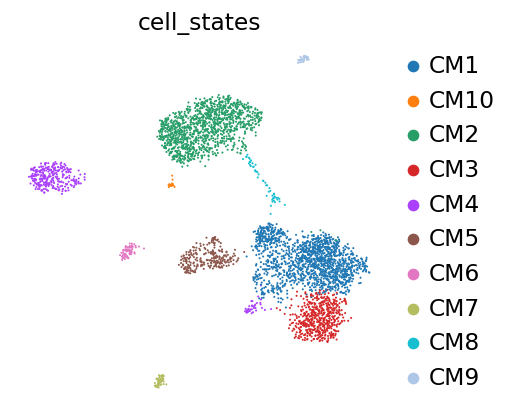

In [14]:
sc.pl.umap(adata, color = ['cell_states'

                          ], size = 6, legend_fontsize = 14, frameon = False, ncols=1, use_raw=True, color_map='coolwarm')

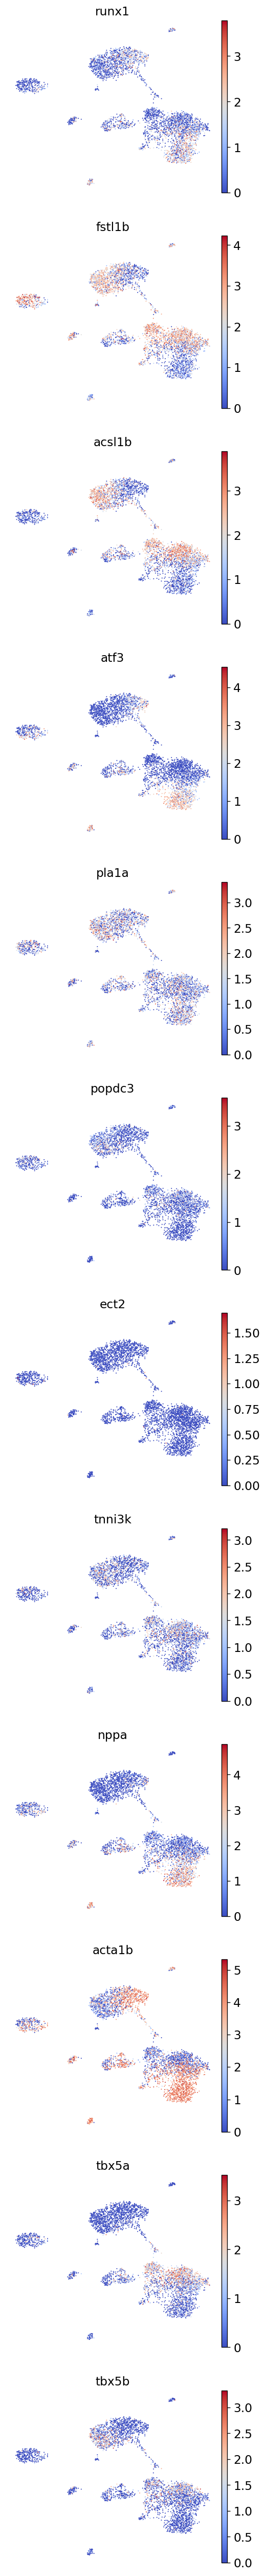

In [15]:

sc.pl.umap(adata, color = ['runx1','fstl1b','acsl1b','atf3','pla1a','popdc3','ect2','tnni3k','nppa','acta1b','tbx5a','tbx5b'
                              ], size = 6, legend_fontsize = 14, frameon = False, ncols=1, use_raw=True, color_map='coolwarm')

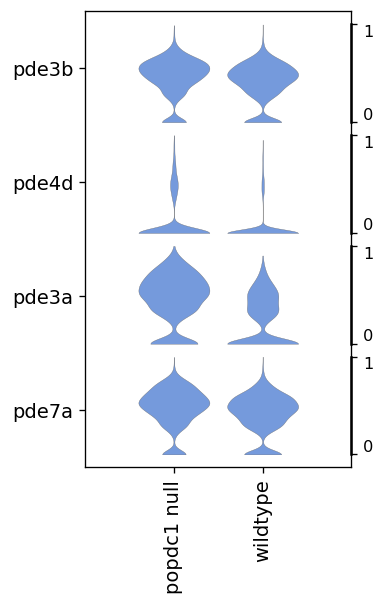

In [16]:
pl = sc.pl.stacked_violin(adata, var_names=['pde3b','pde4d','pde3a','pde7a'], groupby='genotype', figsize=[5,5], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()



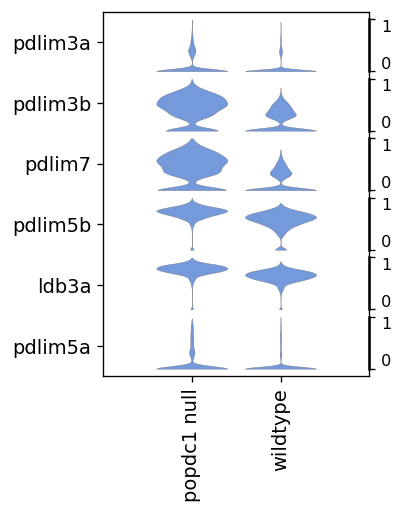

In [17]:
pl = sc.pl.stacked_violin(adata, var_names=['pdlim3a','pdlim3b','pdlim7','pdlim5b','ldb3a' ,'pdlim5a'], groupby='genotype', figsize=[5,4], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

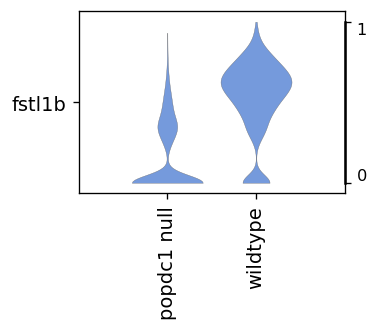

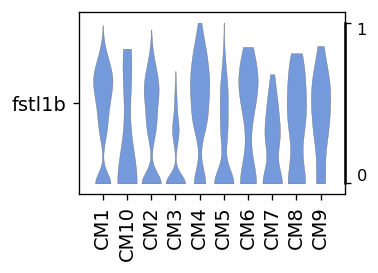

In [35]:
pl = sc.pl.stacked_violin(adata, var_names=['fstl1b'], groupby='genotype', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

pl = sc.pl.stacked_violin(adata, var_names=['fstl1b'], groupby='cell_states', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()


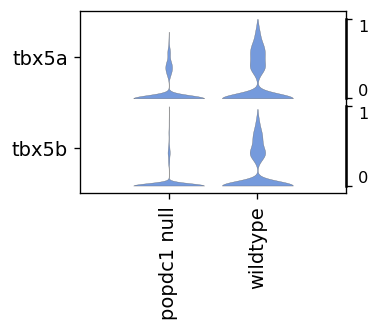

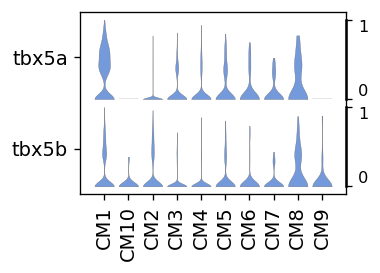

In [34]:
pl = sc.pl.stacked_violin(adata, var_names=['tbx5a','tbx5b'], groupby='genotype', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

pl = sc.pl.stacked_violin(adata, var_names=['tbx5a','tbx5b'], groupby='cell_states', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

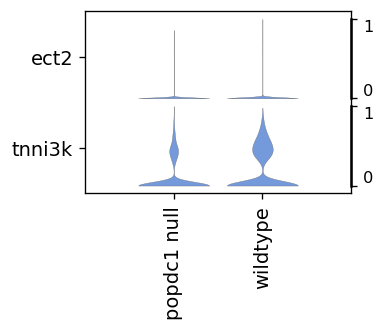

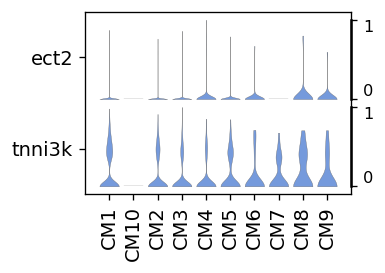

In [38]:
pl = sc.pl.stacked_violin(adata, var_names=['ect2','tnni3k'], groupby='genotype', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

pl = sc.pl.stacked_violin(adata, var_names=['ect2','tnni3k'], groupby='cell_states', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

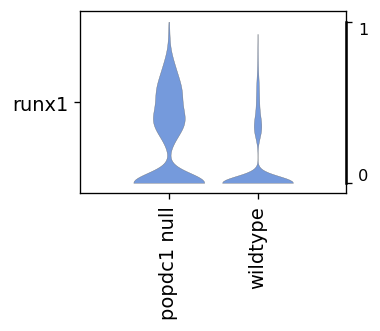

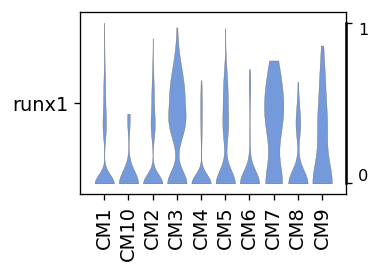

In [33]:
pl = sc.pl.stacked_violin(adata, var_names=[ 'runx1'], groupby='genotype', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

pl = sc.pl.stacked_violin(adata, var_names=[ 'runx1'], groupby='cell_states', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

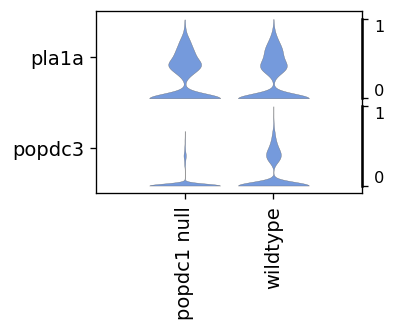

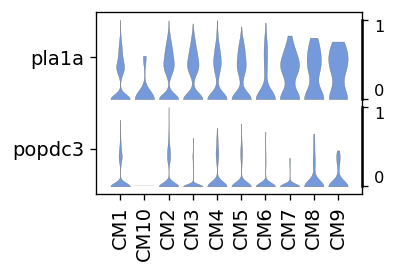

In [37]:
pl = sc.pl.stacked_violin(adata, var_names=[ 'pla1a','popdc3'], groupby='genotype', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

pl = sc.pl.stacked_violin(adata, var_names=[ 'pla1a','popdc3'], groupby='cell_states', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()


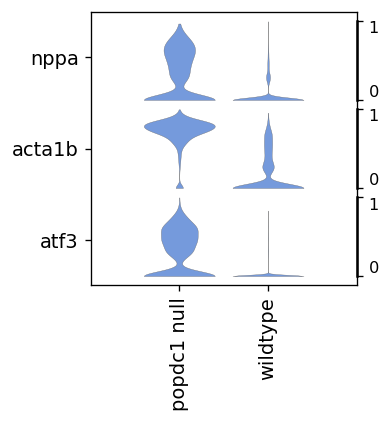

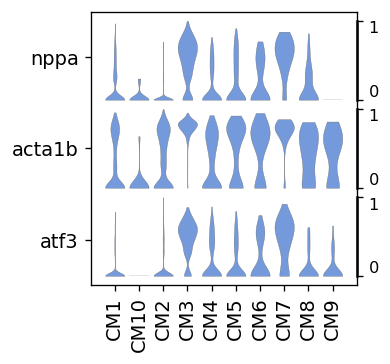

In [39]:
pl = sc.pl.stacked_violin(adata, var_names=[ 'nppa','acta1b','atf3'], groupby='genotype', figsize=[5,3], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

pl = sc.pl.stacked_violin(adata, var_names=[ 'nppa','acta1b','atf3'], groupby='cell_states', figsize=[5,3], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

In [24]:
stress = {'stress': ['nppa','nppb','acta1b','acta1a','atf3','zbtb16a','acta2','actb2','actb1','actc1a','actn1','pdlim5b','pdlim7','pdlim3b','cryabb']
         }

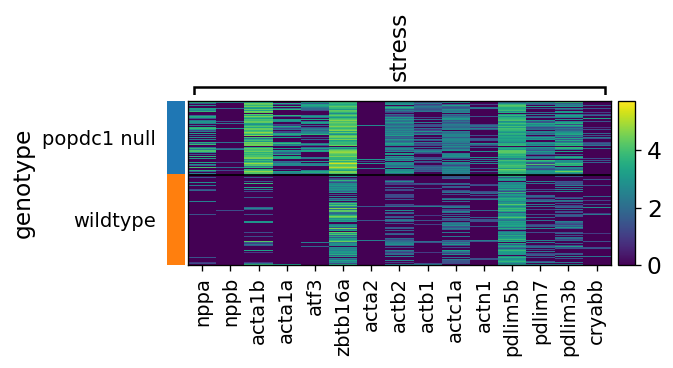

In [25]:
ax = sc.pl.heatmap(adata, stress,  groupby='genotype', cmap='viridis', figsize=(5,2))

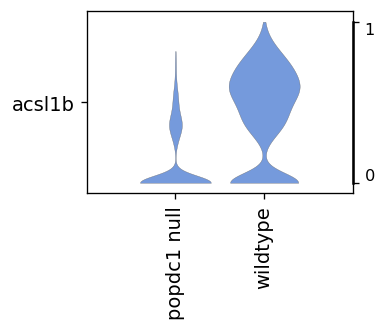

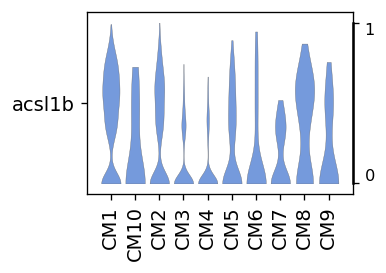

In [36]:
pl = sc.pl.stacked_violin(adata, var_names=[ 'acsl1b'], groupby='genotype', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

pl = sc.pl.stacked_violin(adata, var_names=[ 'acsl1b'], groupby='cell_states', figsize=[5,2], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

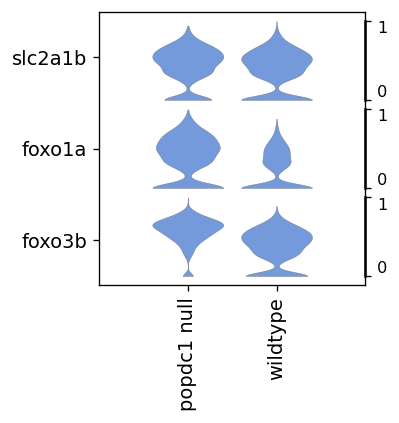

In [26]:
pl = sc.pl.stacked_violin(adata, var_names=[ 'slc2a1b','foxo1a','foxo3b'], groupby='genotype', figsize=[5,3], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

In [27]:
sc.tl.dendrogram(adata, 'cell_states')

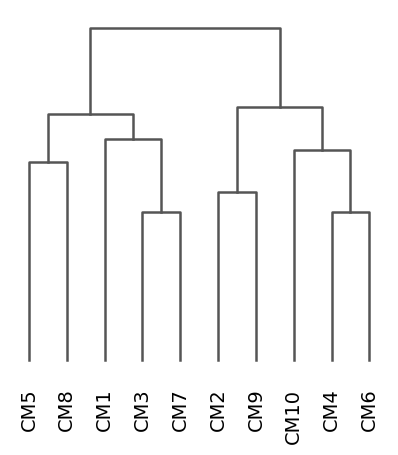

In [28]:
ax = sc.pl.dendrogram(adata, 'cell_states')

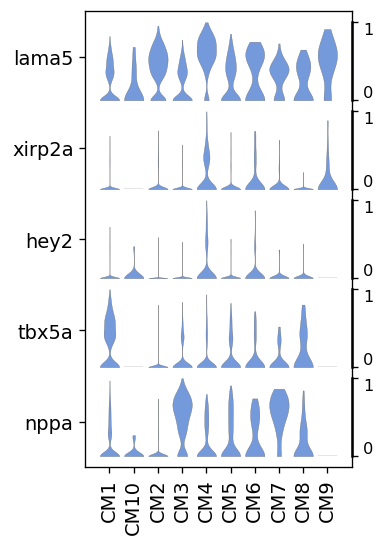

In [29]:
pl = sc.pl.stacked_violin(adata, var_names=[ 'lama5', 'xirp2a', 'hey2', 'tbx5a','nppa'], groupby='cell_states', figsize=[5,5], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

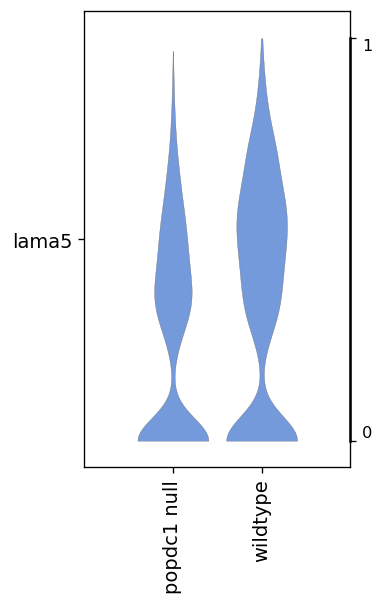

In [30]:
pl = sc.pl.stacked_violin(adata, var_names=[ 'lama5'], groupby='genotype', figsize=[5,5], swap_axes = True, standard_scale = 'var', return_fig=True)
pl.style(yticklabels = True, y_padding = 0, row_palette =('cornflowerblue'), ylim =(0,1)).show()

In [31]:
sc.tl.rank_genes_groups(adata, 'cell_states'
                        , method = 'wilcoxon', use_raw = True)

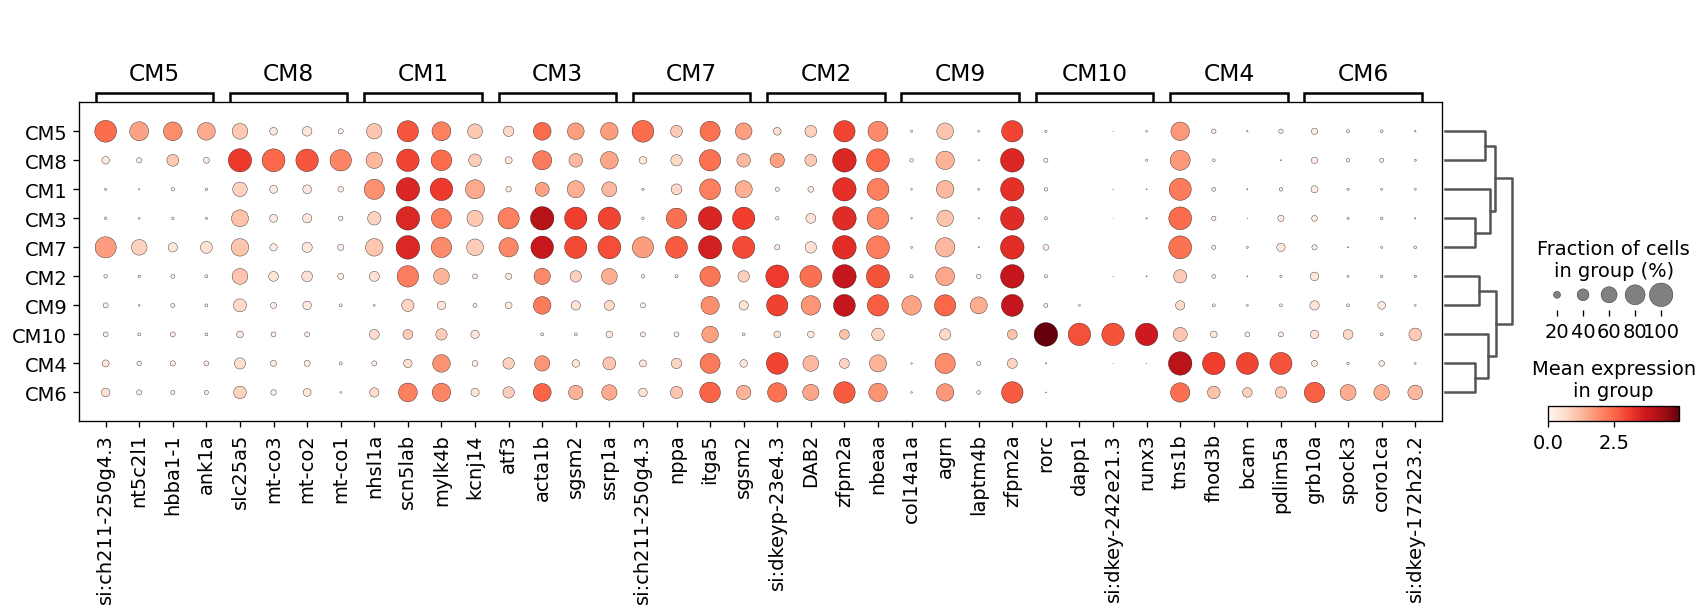

In [32]:
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups', n_genes=4
                                ,use_raw=True
                                #,mean_only_expressed = True
                                #,save='_DEGs_hca_heart_global_ctl200422_wilcox.pdf'
)